In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from prophet import Prophet

import warnings; 
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('~/finance/csv/IBM_financial_data_hourly.csv')
df.head()

,timestamp,open,high,low,close,volume
0,2023-09-18,145.77,146.48,145.06,145.09,2508062
1,2023-09-15,147.11,147.85,145.53,145.99,6234033
2,2023-09-14,147.38,147.73,146.48,147.35,2723200
3,2023-09-13,145.95,146.98,145.92,146.55,2627999
4,2023-09-12,147.92,148.00,145.80,146.30,4457695


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  100 non-null    datetime64[ns]
 1   open       100 non-null    float64       
 2   high       100 non-null    float64       
 3   low        100 non-null    float64       
 4   close      100 non-null    float64       
 5   volume     100 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.8 KB


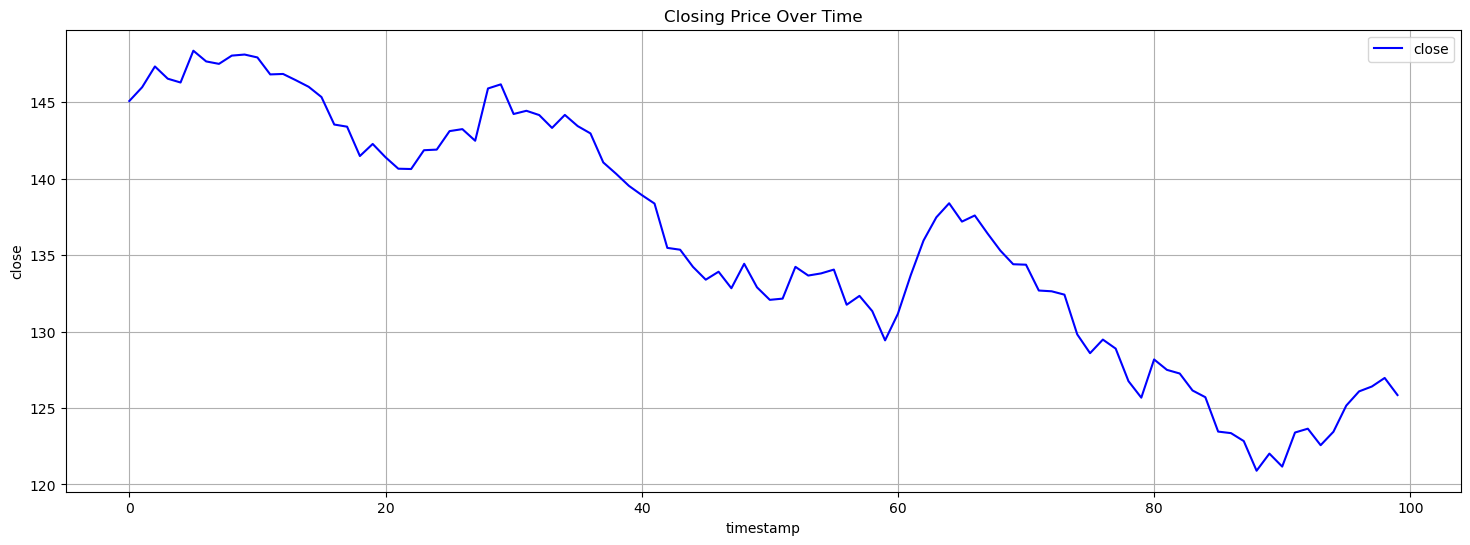

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(df['close'], label='close', color='blue')
plt.title('Closing Price Over Time')
plt.xlabel('timestamp')
plt.ylabel('close')
plt.legend()
plt.grid(True)
plt.show()

The newest info is coming in the last so we need to kinda reverse it

In [6]:
df_indexed = df.set_index('timestamp').sort_index(ascending=True)

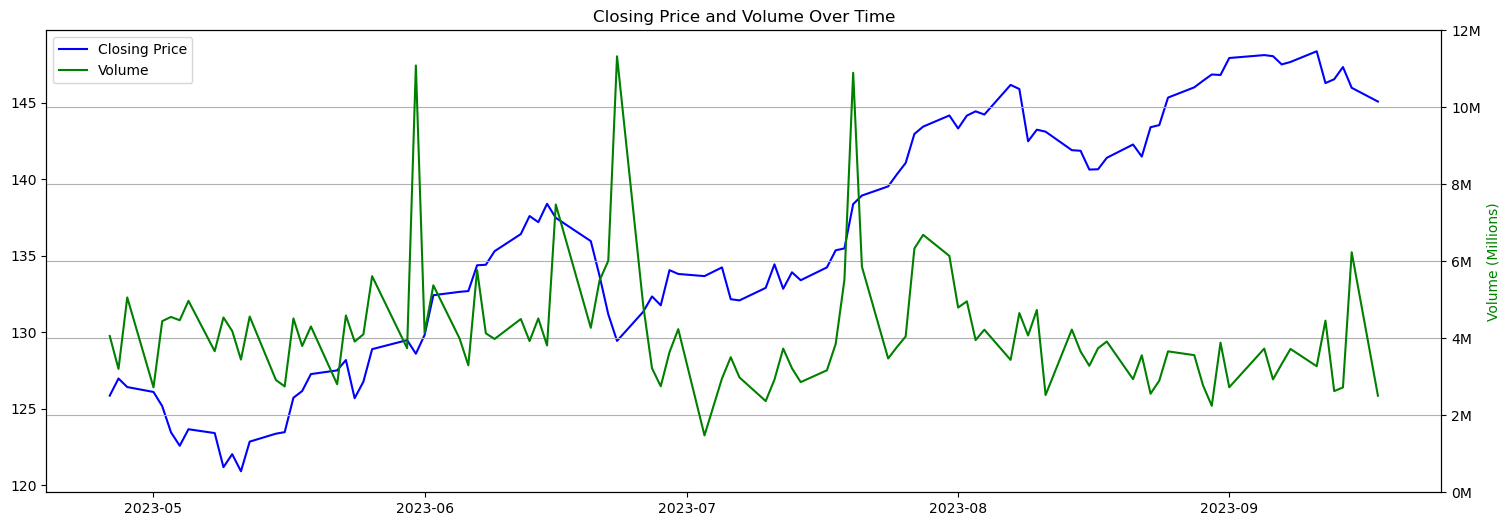

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Plotting the 'Close' data on the main axis and label it 'Closing Price'
close_line, = plt.plot(df_indexed.index, df_indexed['close'], color='blue', label='Closing Price')

# Creating the twinx axis for 'Volume' and label it 'Volume'
ax2 = plt.gca().twinx()
volume_line, = ax2.plot(df_indexed.index, df_indexed['volume'], color='green', label='Volume')

# Customize the y-axis ticks and labels for 'Volume' to display in millions
volume_ticks = ax2.get_yticks() / 1000000
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f'{int(y)}M' for y in volume_ticks])
ax2.set_ylabel('Volume (Millions)', color='green')

# Create a single legend for both lines
plt.legend([close_line, volume_line], ['Closing Price', 'Volume'], loc='upper left')

# Set title, x-label, and grid
plt.title('Closing Price and Volume Over Time')
plt.xlabel('Timestamp')
plt.grid(True)

# Show the plot
plt.show()


Those 3 spikes are quite sus 

In [8]:
df_indexed['returns'] = df_indexed['close'].pct_change()
df_indexed.head()

,open,high,low,close,volume,returns
timestamp,,,,,,
2023-04-26,125.81,126.545,125.120,125.85,4058800,NaN
2023-04-27,126.37,127.020,125.455,126.97,3204889,0.008899
2023-04-28,126.58,127.250,125.640,126.41,5061247,-0.004410
2023-05-01,126.35,126.750,126.060,126.09,2724992,-0.002531
2023-05-02,126.30,126.450,123.270,125.16,4445283,-0.007376


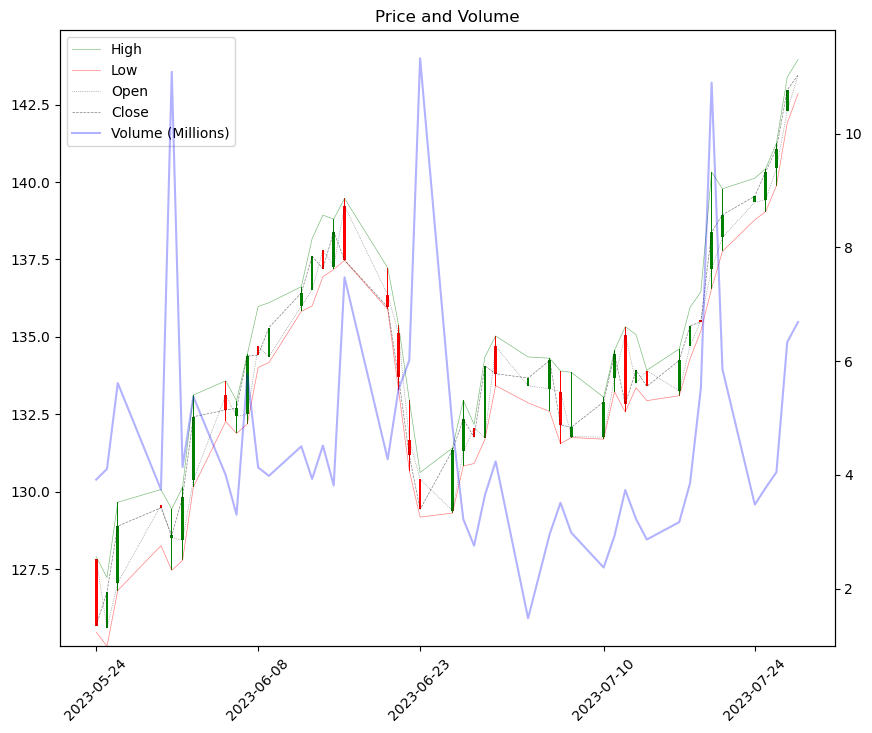

In [9]:
def plot_bars(bars, show_lines=False):
    start_date = '2023-05-24'  
    end_date = '2023-07-28'    
    bars = bars.loc[start_date:end_date]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))
    
    up = bars['close'] >= bars['open']
    
    ax1.bar(bars.index[up], bars.loc[up, 'high'] - bars.loc[up, 'low'], bottom=bars.loc[up, 'low'], color="green", width=0.05)
    ax1.bar(bars.index[~up], bars.loc[~up, 'high'] - bars.loc[~up, 'low'], bottom=bars.loc[~up, 'low'], color="red", width=0.05)
    ax1.bar(bars.index[up], bars.loc[up, 'close'] - bars.loc[up, 'open'], bottom=bars.loc[up, 'open'], color="green", width=0.25)
    ax1.bar(bars.index[~up], bars.loc[~up, 'open'] - bars.loc[~up, 'close'], bottom=bars.loc[~up, 'close'], color="red", width=0.25)
    
    ax2 = ax1.twinx()
    ax2.plot(bars.index, bars['volume'] / 1000000, color='blue', alpha=0.3, label='Volume (Millions)')
    
    
    x_ticks = bars.index[::10]  
    
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels([d.strftime('%Y-%m-%d') for d in x_ticks], rotation=45)
    ax1.set_title('Price and Volume')
    
    lineW = 0.5
    if show_lines:
        ax1.plot(bars['high'], color='green', alpha=0.5, label='High', linewidth=lineW)
        ax1.plot(bars['low'], color='red', alpha=0.5, label='Low', linewidth=lineW)
        ax1.plot(bars['open'], color='black', ls=':', alpha=0.5, label='Open', linewidth=lineW)
        ax1.plot(bars['close'], color='black', ls='--', alpha=0.5, label='Close', linewidth=lineW)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    
    ax1.legend(lines, labels, loc='upper left')
    ax1.grid(False)

plot_bars(df_indexed, show_lines=True)
plt.show()



Lads knew when to pump the money

<AxesSubplot:xlabel='timestamp'>

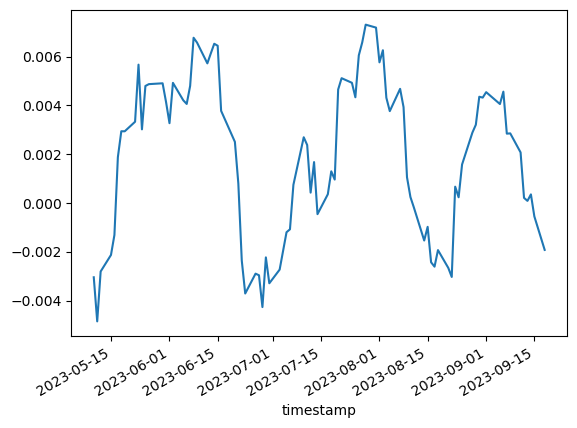

In [10]:
df_indexed['returns'].rolling(10).mean().plot()

The cycles are real even within such a short timeframe

In [11]:
df = df.sort_values(by='timestamp', ascending=True)
df = df.reset_index(drop=True)
df.head()

,timestamp,open,high,low,close,volume
0,2023-04-26,125.81,126.545,125.120,125.85,4058800
1,2023-04-27,126.37,127.020,125.455,126.97,3204889
2,2023-04-28,126.58,127.250,125.640,126.41,5061247
3,2023-05-01,126.35,126.750,126.060,126.09,2724992
4,2023-05-02,126.30,126.450,123.270,125.16,4445283


In [12]:
model = df[['timestamp', 'close']]
model.columns = ['ds', 'y']
model.head()


,ds,y
0,2023-04-26,125.85
1,2023-04-27,126.97
2,2023-04-28,126.41
3,2023-05-01,126.09
4,2023-05-02,125.16


In [13]:
modeled_data = Prophet(interval_width=0.95).fit(model)

20:10:33 - cmdstanpy - INFO - Chain [1] start processing
20:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = modeled_data.make_future_dataframe(periods=10,freq='D')
forecast = modeled_data.predict(future)
forecast.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
100,2023-09-19,147.992890,144.313663,151.444184,147.957384,148.023832,-0.084077,-0.084077,-0.084077,-0.084077,-0.084077,-0.084077,0.0,0.0,0.0,147.908814
101,2023-09-20,148.108662,143.837273,151.472643,147.999280,148.204232,-0.409131,-0.409131,-0.409131,-0.409131,-0.409131,-0.409131,0.0,0.0,0.0,147.699530
102,2023-09-21,148.224433,144.342527,151.692117,148.027931,148.439746,-0.187359,-0.187359,-0.187359,-0.187359,-0.187359,-0.187359,0.0,0.0,0.0,148.037074
103,2023-09-22,148.340204,144.778127,152.071169,148.042475,148.692972,0.075323,0.075323,0.075323,0.075323,0.075323,0.075323,0.0,0.0,0.0,148.415528
104,2023-09-23,148.455976,145.475106,152.512821,148.027045,148.958433,0.411548,0.411548,0.411548,0.411548,0.411548,0.411548,0.0,0.0,0.0,148.867524
105,2023-09-24,148.571747,145.194039,152.764271,147.972830,149.250777,0.411549,0.411549,0.411549,0.411549,0.411549,0.411549,0.0,0.0,0.0,148.983296
106,2023-09-25,148.687519,144.586213,152.190726,147.948547,149.550460,-0.217853,-0.217853,-0.217853,-0.217853,-0.217853,-0.217853,0.0,0.0,0.0,148.469665
107,2023-09-26,148.803290,145.124662,152.336850,147.885877,149.820815,-0.084077,-0.084077,-0.084077,-0.084077,-0.084077,-0.084077,0.0,0.0,0.0,148.719213
108,2023-09-27,148.919061,144.870321,152.468184,147.736998,150.122484,-0.409131,-0.409131,-0.409131,-0.409131,-0.409131,-0.409131,0.0,0.0,0.0,148.509930
109,2023-09-28,149.034833,144.931853,152.617146,147.710153,150.456115,-0.187359,-0.187359,-0.187359,-0.187359,-0.187359,-0.187359,0.0,0.0,0.0,148.847474


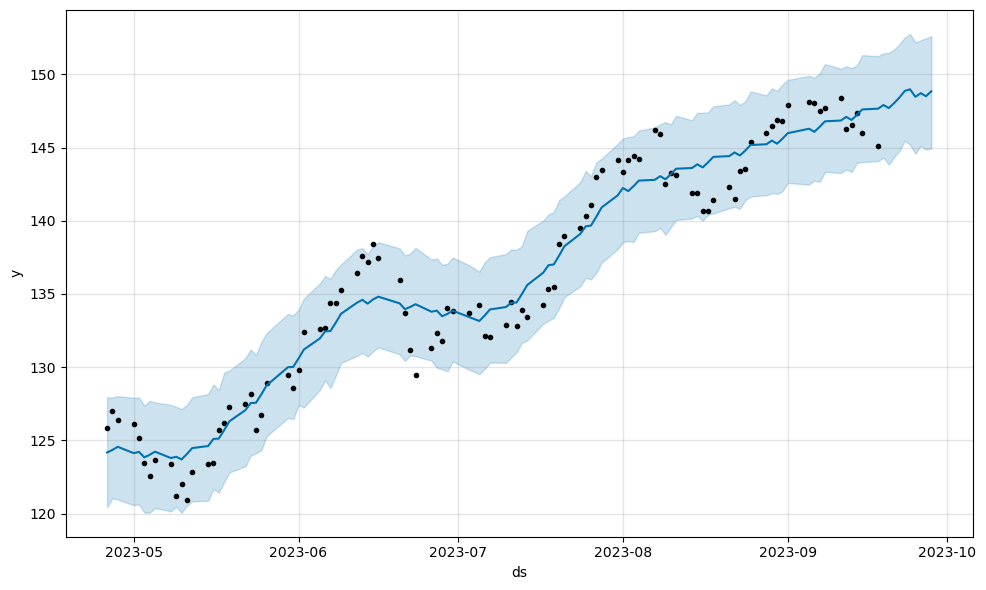

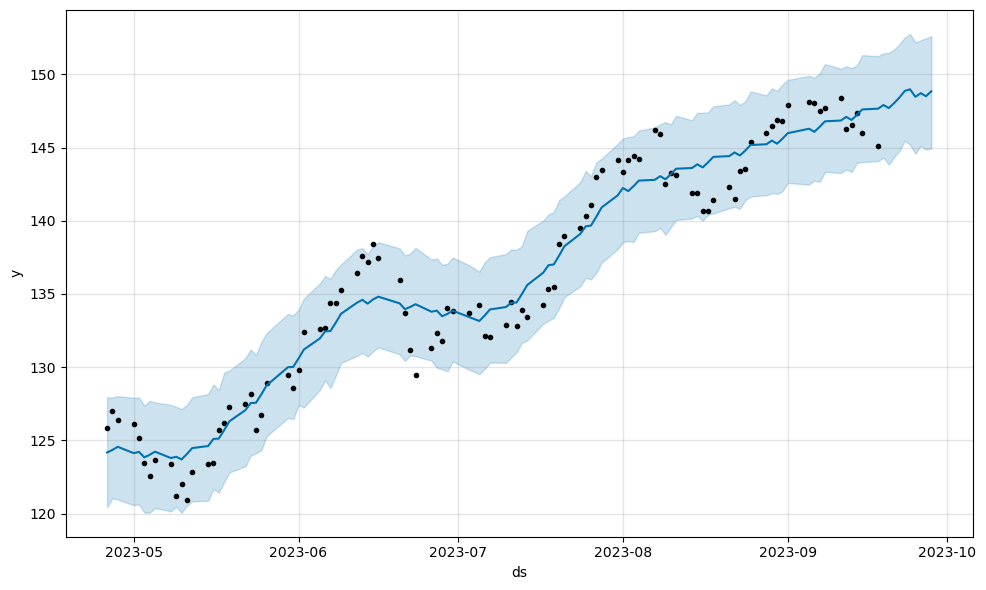

In [18]:
modeled_data.plot(forecast)